# <span style="color:black; font-weight:bold;">MERFISH Coronal Mouse Brain Sample Integration Tutorial</span>
#### • <span style="color:black; font-weight:bold;">Creator</span>: Bingjie Dai (17516970902@163.com)
#### • <span style="color:black; font-weight:bold;">Date of Creation</span>: 2.11.2026
#### • <span style="color:black; font-weight:bold;">Date of Last Modification</span>: 2.11.2026


<span style="color:black; font-weight:bold;">The dataset have:</span>   
• <span style="color:black; font-weight:bold;">MERFISH_-1.076</span>: 42,854 cells and 1122 genes   
• <span style="color:black; font-weight:bold;">MERFISH_-1.077</span>: 43,968 cells and 1122 genes  
• <span style="color:black; font-weight:bold;">MERFISH_-1.078</span>: 45,393 cells and 1122 genes  
• <span style="color:black; font-weight:bold;">Total</span>: 132,215 cells and 1022 genes

In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.LP import SpatialLocalPooling
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

## <span style="color:black; font-weight:bold;">Loading MERFISH Mouse Brain Sample Integration data</span>

In [36]:
adata_batch1 = sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/MERFISH_-1.076.h5ad')
adata_batch2 = sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/MERFISH_-1.077.h5ad')
adata_batch3 = sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/STARmapPLUS/MERFISH_-1.078.h5ad')

In [5]:
adata_list=[adata_batch1,adata_batch2,adata_batch3]
adata = ad.concat(adata_list, join="inner")

In [34]:
adata

AnnData object with n_obs × n_vars = 132215 × 1122
    obs: 'donor_id', 'development_stage_ontology_term_id', 'sex_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'disease_ontology_term_id', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'suspension_type', 'cluster_id_transfer', 'subclass_transfer', 'cluster_confidence_score', 'subclass_confidence_score', 'high_quality_transfer', 'major_brain_region', 'ccf_region_name', 'brain_section_label', 'tissue_type', 'is_primary_data', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'slice', 'SpaLP'
    uns: 'neighbors', 'umap', 'leiden', 'slice_colors', 'major_brain_region_colors', 'SpaLP_colors'
    obsm: 'X_CCF', 'X_spatial_coords', 'X_umap', 'spatial', 'feat', 'SpaLP'
    obsp: 'distances', 'connectivities'

## <span style="color:black; font-weight:bold;">Data preprocessing</span>
We use [scanpy](https://scanpy.readthedocs.io/en/stable/installation.html) package to preprocess each batch separately and combine them as standard processed expression matrix.  
The standard processed expression matrix was saved in adata.obsm[<span style="color:red;">'feat'</span>] and used as input to the model.

In [8]:
adatas = []
for batch in adata.obs['slice'].unique():
    a = adata[adata.obs['slice'] == batch].copy()
    sc.pp.normalize_total(a,inplace=True)
    sc.pp.log1p(a)
    sc.pp.scale(a)
    adatas.append(a)

adata = ad.concat(adatas, join="inner")
adata.obsm['feat']=adata.X

## <span style="color:black; font-weight:bold;">Compute Spatial Neighbor Graph and build the neighbor index matrix</span>
We compute the spatial Graph using 8 neighbors in MERFISH Mouse Brain Sample Integration data. k=8  
We will compute a separate spatial neighbor index matrix for each sample and combine them as disconnected components.

In [9]:
graphs = []
for batch in adata.obs['slice'].unique():
    a = adata[adata.obs['slice'] == batch].copy()
    graph = prepare_inputs(a, k=8, device=device)
    graphs.append(graph)

In [10]:
all_features = torch.cat([g.features for g in graphs], dim=0)
all_neighbor_idx = []
offset = 0
for g in graphs:
    all_neighbor_idx.append(g.neighbor_idx + offset)
    offset += g.features.shape[0]
all_neighbor_idx = torch.cat(all_neighbor_idx, dim=0)

graph = Graph(all_features, all_neighbor_idx)

## <span style="color:black; font-weight:bold;">Define Parameters</span>
The hidden layer dimension is 64, the Adam optimizer is used to optimize the model, the learning rate lr is 0.001, and the model is trained for 200 epochs.

In [11]:
in_channels = graph.features.shape[1]
model = SpatialLocalPooling(in_channels, out_channels=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.71it/s, Epoch=199, Loss=0.9192]


## <span style="color:black; font-weight:bold;">Generate cell embedding and reconstructed gene expression</span>
Cell embedding was saved in adata.obsm[<span style="color:red;">'SpaLP'</span>]. Reconstructed gene expression is constructed as adata2

In [13]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

### Cell embedding

In [14]:
adata.obsm['SpaLP']=embedding

## <span style="color:black; font-weight:bold;">Identify Niches and Visualization of Multi-slice Integration embedding Using UMAP</span>
We compute Leiden clustering based on the SpaLP embeddings to identify spatial niches.

In [15]:
%%time
sc.pp.neighbors(adata, use_rep='SpaLP')
sc.tl.umap(adata)
sc.tl.leiden(adata,resolution=0.35,key_added='SpaLP')

CPU times: user 12min 35s, sys: 15min 59s, total: 28min 34s
Wall time: 3min 18s


### <span style="color:black; font-weight:bold;">Multi-slice Integration embedding</span>

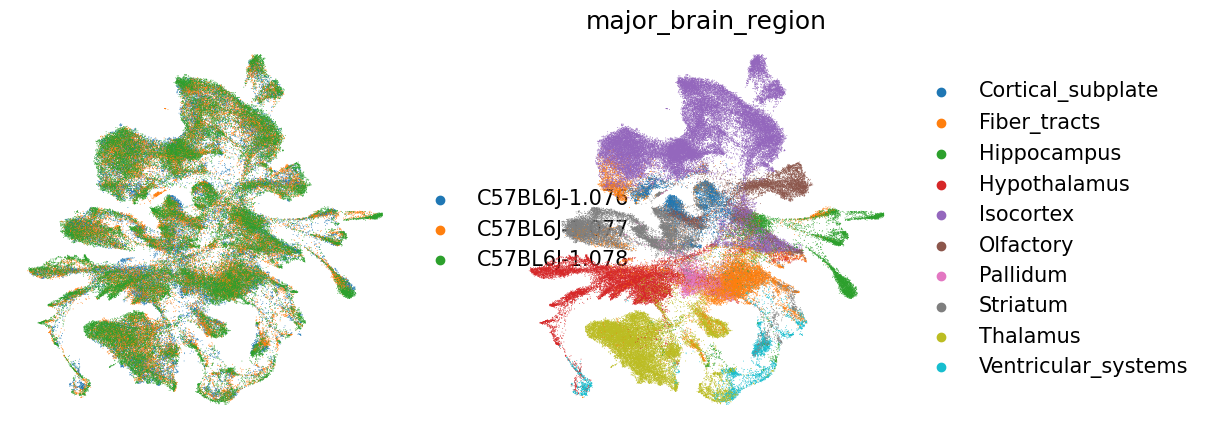

In [31]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 15
sc.pl.umap(adata=adata,color=['slice','major_brain_region'],title='',size=1.5,colorbar_loc=None,frameon=False)

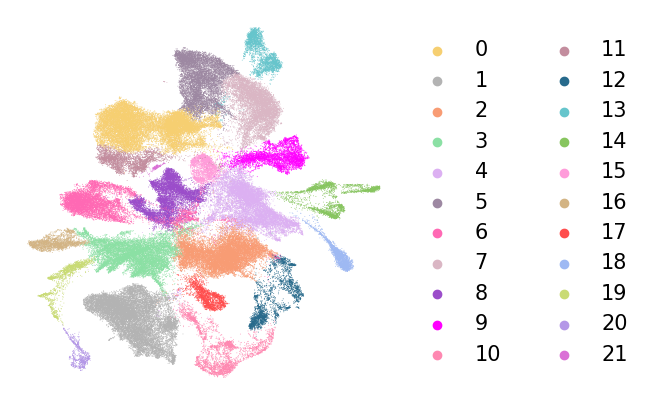

In [27]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (5,5)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
sc.pl.umap(adata=adata,color='SpaLP',title='',size=1.5,colorbar_loc=None,frameon=False,palette=latent_cluster_colors)

## <span style="color:black; font-weight:bold;">Major_brain_region_annotation and Niche identified by SpaLP</span>

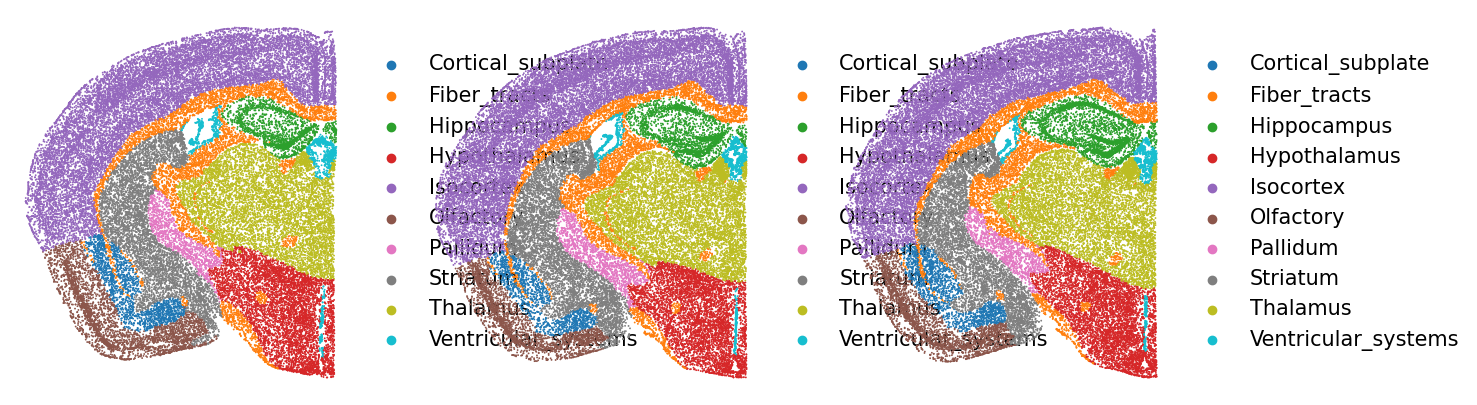

In [33]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
samples = adata.obs['slice'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(5 * len(samples), 5))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['slice'] == sample],basis='spatial',color=['major_brain_region'],frameon=False,title='',ax=axs[idx],show=False,size=7)

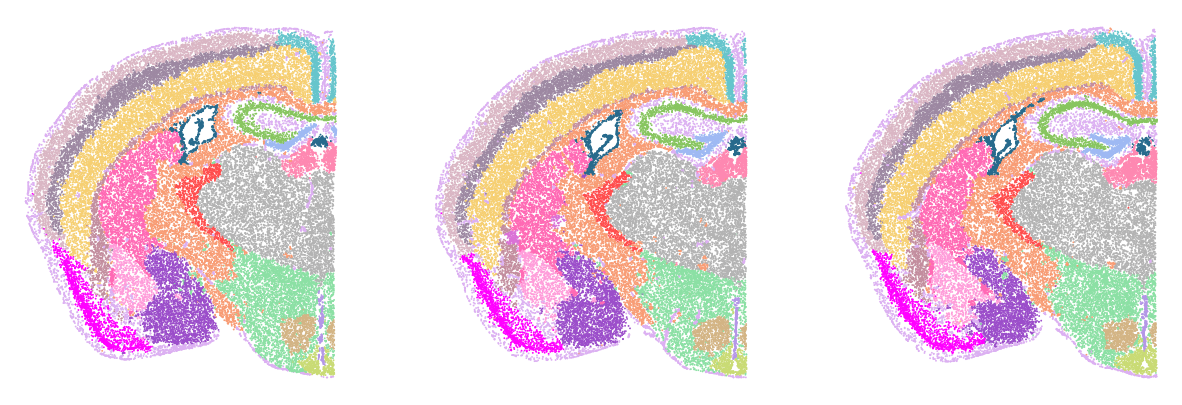

In [26]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,8)
plt.rcParams['font.size'] = 15
latent_cluster_colors = create_new_color_dict(adata=adata,cat_key='SpaLP')
samples = adata.obs['slice'].unique().tolist()
fig, axs = plt.subplots(1, len(samples), figsize=(5 * len(samples), 5))
if len(samples) == 1:
    axs = [axs]
for idx, sample in enumerate(samples):
    sc.pl.embedding(adata=adata[adata.obs['slice'] == sample],basis='spatial',color=['SpaLP'],legend_loc=None,frameon=False,title='',palette=latent_cluster_colors,ax=axs[idx],show=False,size=7)